## 0.导入库

In [15]:
# 导入常用的库
import time
import string
import random
# 导入加密解密的库hashlib
import hashlib
# 导入发起网络请求的库requests
import requests
# 导入字典的易用库easydict
from easydict import EasyDict
# 导入解析符合xml规范字符串的库lxml
from lxml import etree
# 导入代码文件config.py中的字典config_dict
from config import config_dict
# 导入把url链接转换为二维码图像的库qrcode
import qrcode

## 1. 定义方法和类

In [4]:
class WechatPayError(Exception):
    def __init__(self, message):
        super(WeixinPayError, self).__init__(message)

In [32]:
class WechatPay(object):
    # 把config_dict的键值对传递给对象的属性default_dict
    def __init__(self):
        self.default_dict = EasyDict()
        self.appid = config_dict['appid']
        self.mch_id = config_dict['mch_id']
        self.password = config_dict['password']
    
    # 获取随机的字符串
    def get_nonce_str(self):
        char_list = string.ascii_letters + string.digits
        nonce_str = "".join(random.choice(char_list) for _ in range(32))
        return nonce_str
    
    # 获取签名
    def get_sign(self, argument_dict):
        sorted_keys = sorted(argument_dict.keys())
        hash_string = ''
        for i, key in enumerate(sorted_keys):
            value = str(argument_dict[key])
            if value != "" and i > 0:
                hash_string += '&%s=%s' %(key, value)
            elif value != "" and i == 0:
                hash_string += '%s=%s' %(key, value)
        hash_string += "&key=%s" %self.password
        hash_bytes = hash_string.encode('utf-8')
        hash_result = hashlib.md5(hash_bytes).hexdigest()
        sign = hash_result.upper()
        return sign
    
    # 把表示参数的字典转换为xml格式的字符串 
    def to_xml(self, argument_dict):
        xml_string = ""
        for key, value in argument_dict.items():
            xml_string += '<{0}>{1}</{0}>'.format(key, value)
        xml_string = '<xml>%s</xml>' %xml_string
        return xml_string
    
    # 把xml格式的字符串转换为字典
    def to_dict(self, xml_string):
        result_dict = {}
        root = etree.fromstring(xml_string)
        for child in root:
            result_dict[child.tag] = child.text
        return result_dict
    
    # 获取表示响应信息的字典
    def get_response_dict(self, url, **argument_dict):
        # 根据密钥生成签名
        argument_dict['nonce_str'] = self.get_nonce_str()
        argument_dict['sign'] = self.get_sign(argument_dict)
        header_dict = {'Content-Type': 'text/xml; charset=UTF-8'}
        xml_string = self.to_xml(argument_dict)
        xml_bytes = xml_string.encode('utf8')
        response = requests.post(url, data=xml_bytes, headers=header_dict)
        response.encoding = 'utf8'
        response_content = response.text
        response_dict = self.to_dict(response_content)
        return response_dict
    
    # 创建支付订单
    def open_order(self, **kwargs):
        url = 'https://api.mch.weixin.qq.com/pay/unifiedorder'
        argument_dict = EasyDict()
        argument_dict.appid = self.appid
        argument_dict.mch_id = self.mch_id
        argument_dict.device_info = 'web'
        argument_dict.body = 'Native支付测试'
        argument_dict.spbill_create_ip = '192.168.0.153'
        argument_dict.notify_url = 'http://wxpay.wxutil.com/pub_v2/pay/notify.v2.php'
        argument_dict.trade_type = 'NATIVE'
        argument_dict.update(kwargs)
        response_dict = self.get_response_dict(url, **argument_dict)
        return response_dict
    
    def query_order(self, **kwargs):
        url = 'https://api.mch.weixin.qq.com/pay/orderquery' 
        argument_dict = EasyDict()
        argument_dict.appid = self.appid
        argument_dict.mch_id = self.mch_id
        argument_dict.update(kwargs)
        response_dict = self.get_response_dict(url, **argument_dict)
        return response_dict


# 获取二维码图像
def get_qrcode_image(url):
    qrcode_maker = qrcode.QRCode()
    qrcode_maker.add_data(url)
    qrcode_image = qrcode_maker.make_image()
    return qrcode_image    

## 1.创建订单示例

In [33]:
wechat_pay = WechatPay()

In [25]:
out_trade_no = '10000007'
total_fee = 1
response_dict = weixin_pay.open_order(out_trade_no=out_trade_no, total_fee=total_fee)
response_dict

{'return_code': 'SUCCESS',
 'return_msg': 'OK',
 'appid': 'wx820bee8852e87032',
 'mch_id': '1521151201',
 'device_info': 'web',
 'nonce_str': 'XxRPUGKQrat655ag',
 'sign': '23AC71F9CC8FF0D96B59F18D72EB61D9',
 'result_code': 'SUCCESS',
 'prepay_id': 'wx0418190094100316b0a16c9f1585771000',
 'trade_type': 'NATIVE',
 'code_url': 'weixin://wxpay/bizpayurl?pr=4TKBLjy'}

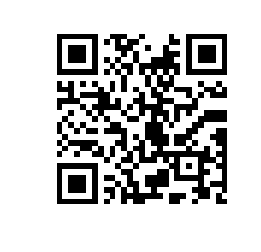

In [26]:
url = response_dict['code_url']
qrcode_image = get_qrcode_image(url)
import matplotlib.pyplot as plt
plt.imshow(qrcode_image)
plt.axis('off')
plt.show()

## 2.未支付时，查询订单

In [34]:
response_dict = wechat_pay.query_order(out_trade_no=out_trade_no)
response_dict

{'return_code': 'SUCCESS',
 'return_msg': 'OK',
 'appid': 'wx820bee8852e87032',
 'mch_id': '1521151201',
 'device_info': 'web',
 'nonce_str': '9q8wcYnAmiVRtuRL',
 'sign': 'A1B9A836674D6244BC6BC354805BC0A0',
 'result_code': 'SUCCESS',
 'total_fee': '1',
 'out_trade_no': '10000007',
 'trade_state': 'NOTPAY',
 'trade_state_desc': '订单未支付'}

## 3.用手机支付后，查询订单

In [36]:
response_dict = wechat_pay.query_order(out_trade_no=out_trade_no)
response_dict

{'return_code': 'SUCCESS',
 'return_msg': 'OK',
 'appid': 'wx820bee8852e87032',
 'mch_id': '1521151201',
 'device_info': 'web',
 'nonce_str': 'lnzcsJKmtUlCsUj7',
 'sign': '5D2365A4A869EAF5F355D1E1A9D500EB',
 'result_code': 'SUCCESS',
 'openid': 'o1QoA0wQ2B3iiFJTlMmMXaLZwfco',
 'is_subscribe': 'N',
 'trade_type': 'NATIVE',
 'bank_type': 'CFT',
 'total_fee': '1',
 'fee_type': 'CNY',
 'transaction_id': '4200000346201908046844648327',
 'out_trade_no': '10000007',
 'attach': '',
 'time_end': '20190804182203',
 'trade_state': 'SUCCESS',
 'cash_fee': '1',
 'trade_state_desc': '支付成功'}